In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cross support for windows and linux
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
data_path = os.path.join(project_root, 'data', 'raw', 'fake_and_real_news.csv')
model_path = os.path.join(project_root, 'models', 'final_model.pk1')

In [3]:
from utils.model_utils import load_model

In [4]:
trained_model = load_model(model_path)

In [5]:
print(trained_model)

Pipeline(steps=[('mean_vector', WordEmbedder()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=70))])


In [6]:
from sklearn.model_selection import train_test_split

data = pd.read_csv(data_path)

mapping = {"Fake": 1, "Real":0}
data["label_binary"] = data["label"].map(mapping)
data.drop_duplicates(subset="Text", inplace = True)

X = data['Text']
y = data['label_binary']

# split into training testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2024)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

pred = trained_model.predict(X_test)
print("Classification Report")
print(classification_report(y_test, pred, target_names=["Real", "Fake"]))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, pred))

Classification Report
              precision    recall  f1-score   support

        Real       0.96      0.98      0.97      1454
        Fake       0.98      0.96      0.97      1506

    accuracy                           0.97      2960
   macro avg       0.97      0.97      0.97      2960
weighted avg       0.97      0.97      0.97      2960

Confusion Matrix: 
[[1420   34]
 [  53 1453]]


In [8]:
y_pred_prob = trained_model.predict_proba(X_test)[:,1]

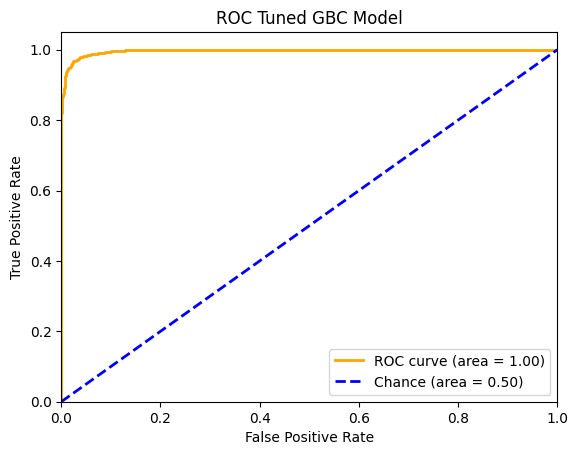

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label="Chance (area = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Tuned GBC Model')
plt.legend(loc="lower right")
plt.show()

In [10]:
from src.validations import cross_val_train_val_scores, plot_train_val_scores

In [11]:
from src.pipelines import create_best_gbc_pipe

# new instance of tuned gbc for fresh cross validation
final_pipe = create_best_gbc_pipe()
print(final_pipe)

Pipeline(steps=[('mean_vector', WordEmbedder()),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=70))])


In [13]:
X_arr = np.array(X)
y_arr = np.array(y)

# obtain cross validation scores
train_scores, val_scores = cross_val_train_val_scores(final_pipe, X_arr, y_arr, cv=5)

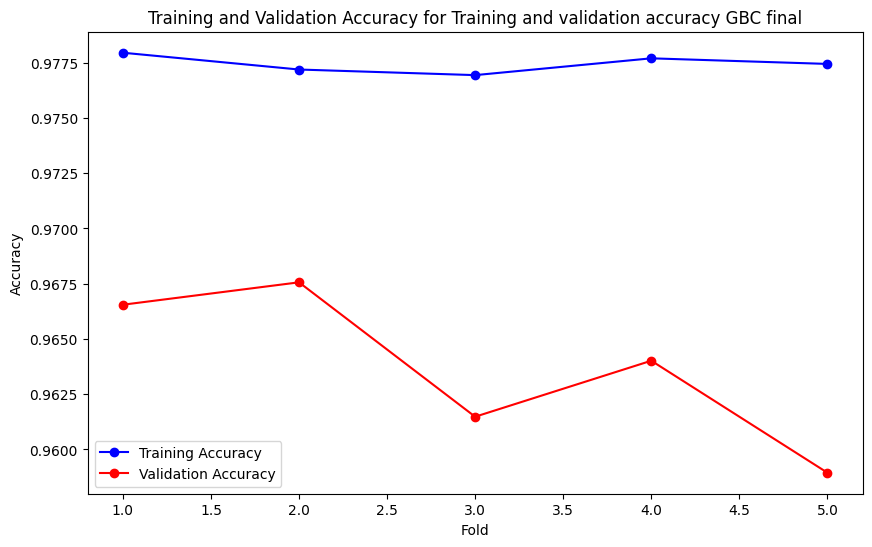

In [14]:
# plot the scores
plot_train_val_scores(train_scores, val_scores, 'Training and validation accuracy GBC final')